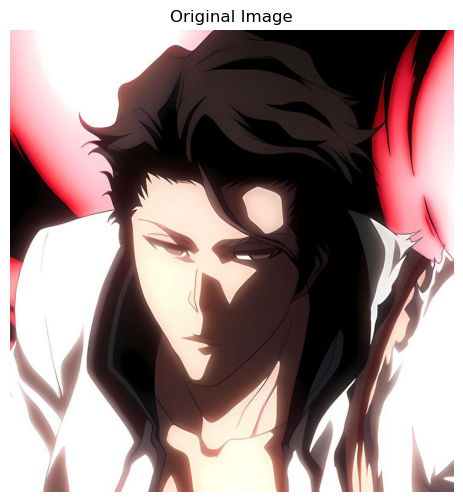

Lossy Compression (JPEG) saved at: compressed_image.jpeg


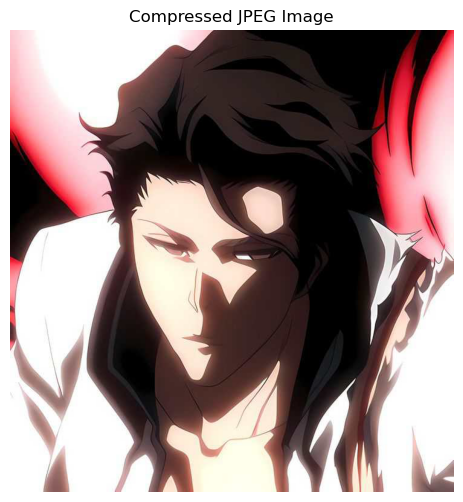

Lossless Compression (PNG) saved at: compressed_image.png


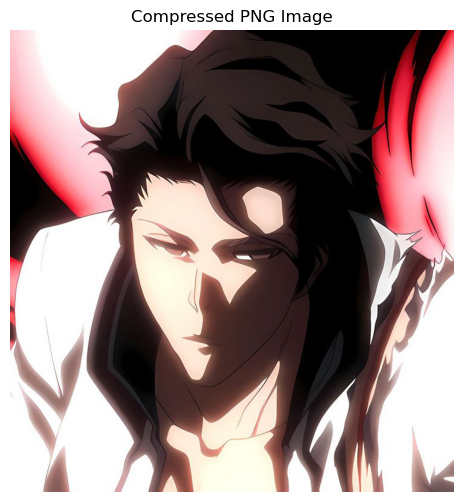

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

def compress_image(input_path, output_path_jpeg, output_path_png, quality=50):
    # Open the image
    img = Image.open(input_path)
    
    # Display original image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Original Image")
    plt.show()
    
    # Lossy Compression - JPEG
    img.save(output_path_jpeg, "JPEG", quality=quality)
    print(f"Lossy Compression (JPEG) saved at: {output_path_jpeg}")
    
    # Display compressed JPEG image
    compressed_jpeg = Image.open(output_path_jpeg)
    plt.figure(figsize=(6, 6))
    plt.imshow(compressed_jpeg)
    plt.axis("off")
    plt.title("Compressed JPEG Image")
    plt.show()
    
    # Lossless Compression - PNG
    img.save(output_path_png, "PNG", optimize=True)
    print(f"Lossless Compression (PNG) saved at: {output_path_png}")
    
    # Display compressed PNG image
    compressed_png = Image.open(output_path_png)
    plt.figure(figsize=(6, 6))
    plt.imshow(compressed_png)
    plt.axis("off")
    plt.title("Compressed PNG Image")
    plt.show()

# Example usage
input_image = "21cba8b2cb748c824db6f2ea0863d6c9.jpg"  # Change this to your input image path
output_jpeg = "compressed_image.jpeg"
output_png = "compressed_image.png"

compress_image(input_image, output_jpeg, output_png, quality=50)

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

def rle_encode(image):
    flat = image.flatten()
    encoded = []
    prev_pixel = flat[0]
    count = 1
    for pixel in flat[1:]:
        if pixel == prev_pixel:
            count += 1
        else:
            encoded.append((prev_pixel, count))
            prev_pixel = pixel
            count = 1
    encoded.append((prev_pixel, count))
    return encoded

def rle_decode(encoded, shape):
    flat = np.concatenate([np.full(count, pixel) for pixel, count in encoded])
    return flat.reshape(shape)

def dct_compress(image, quality=50):
    image = np.float32(image) - 128
    h, w = image.shape
    compressed = np.zeros((h, w))
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = image[i:i+8, j:j+8]
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            quant_matrix = np.ones((8, 8)) * (100 - quality)
            compressed[i:i+8, j:j+8] = np.round(dct_block / quant_matrix)
    return compressed

def dct_decompress(compressed, quality=50):
    h, w = compressed.shape
    decompressed = np.zeros((h, w))
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = compressed[i:i+8, j:j+8]
            quant_matrix = np.ones((8, 8)) * (100 - quality)
            idct_block = idct(idct(block * quant_matrix.T, norm='ortho').T, norm='ortho')
            decompressed[i:i+8, j:j+8] = idct_block
    return np.clip(decompressed + 128, 0, 255).astype(np.uint8)

# Load image
def process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Lossless Compression (RLE)
    rle_encoded = rle_encode(image)
    rle_decoded = rle_decode(rle_encoded, image.shape)
    
    # Lossy Compression (DCT)
    dct_compressed = dct_compress(image)
    dct_decompressed = dct_decompress(dct_compressed)
    
    # Display results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("RLE Decoded Image")
    plt.imshow(rle_decoded, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("DCT Decompressed Image")
    plt.imshow(dct_decompressed, cmap='gray')
    plt.show()
process_image('21cba8b2cb748c824db6f2ea0863d6c9.jpg')


ValueError: operands could not be broadcast together with shapes (8,7) (8,8) 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Build CNN model
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), strides=1, activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), strides=1, activation='relu'),
        layers.AvgPool2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Compile and train model
model = create_cnn_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, validation_split=0.2, batch_size=32)

# Evaluate model
y_pred = np.argmax(model.predict(x_test), axis=1)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, model.predict(x_test).ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Repeat for CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize

# Build and train CIFAR-10 model
model = create_cnn_model()
model.fit(x_train, y_train, epochs=5, validation_split=0.2, batch_size=32)
y_pred = np.argmax(model.predict(x_test), axis=1)

# CIFAR-10 Metrics
accuracy = np.mean(y_pred.flatten() == y_test.flatten())
print(f"CIFAR-10 Accuracy: {accuracy:.4f}")
print(classification_report(y_test.flatten(), y_pred))


Epoch 1/5
938/938 [==============================] - 16s 16ms/step - loss: 0.2379 - accuracy: 0.9320 - val_loss: 0.0923 - val_accuracy: 0.9716
Epoch 2/5
938/938 [==============================] - 10s 10ms/step - loss: 0.0783 - accuracy: 0.9764 - val_loss: 0.0663 - val_accuracy: 0.9791
Epoch 3/5
938/938 [==============================] - 10s 10ms/step - loss: 0.0522 - accuracy: 0.9842 - val_loss: 0.0577 - val_accuracy: 0.9817
Epoch 4/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0375 - accuracy: 0.9884 - val_loss: 0.0518 - val_accuracy: 0.9840
Epoch 5/5
313/313 [==============================] - 1s 3ms/step
Classification Report (Strided Conv):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.96      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.97      0.99      0.98       982


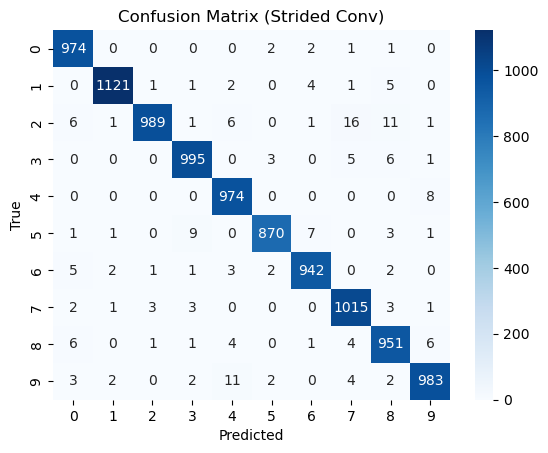

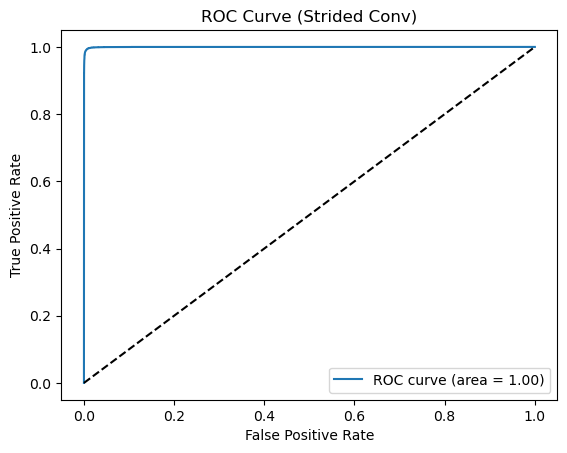

Epoch 1/5
938/938 [==============================] - 22s 23ms/step - loss: 0.2026 - accuracy: 0.9419 - val_loss: 0.0796 - val_accuracy: 0.9763
Epoch 2/5
938/938 [==============================] - 20s 22ms/step - loss: 0.0670 - accuracy: 0.9802 - val_loss: 0.0519 - val_accuracy: 0.9814
Epoch 3/5
938/938 [==============================] - 21s 23ms/step - loss: 0.0457 - accuracy: 0.9863 - val_loss: 0.0517 - val_accuracy: 0.9817
Epoch 4/5
938/938 [==============================] - 22s 23ms/step - loss: 0.0332 - accuracy: 0.9899 - val_loss: 0.0494 - val_accuracy: 0.9838
Epoch 5/5
313/313 [==============================] - 2s 6ms/step
Classification Report (Max Pooling):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.95      1.00      0.98      1010
           4       0.98      1.00      0.99       982
 

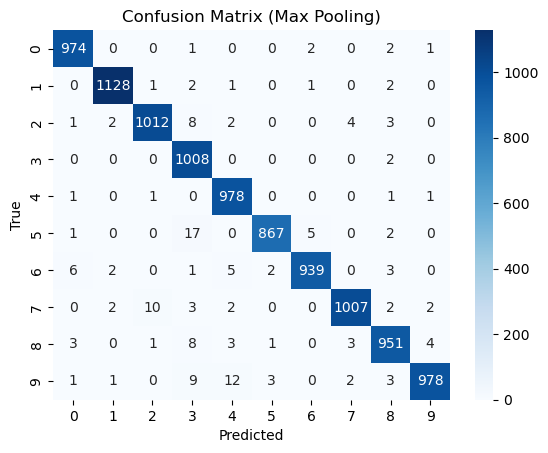

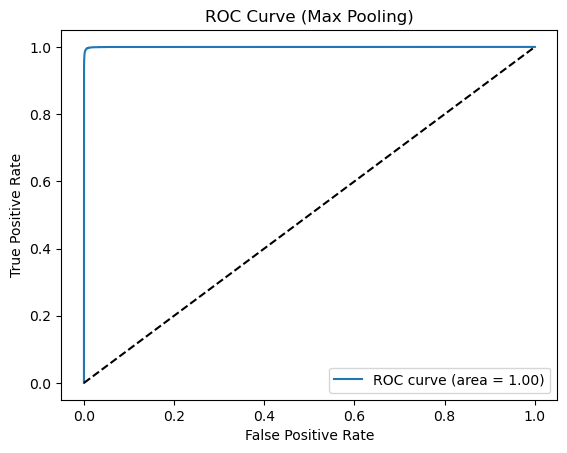

Epoch 1/5
938/938 [==============================] - 23s 23ms/step - loss: 0.2427 - accuracy: 0.9315 - val_loss: 0.1027 - val_accuracy: 0.9689
Epoch 2/5
938/938 [==============================] - 20s 22ms/step - loss: 0.0803 - accuracy: 0.9764 - val_loss: 0.0646 - val_accuracy: 0.9799
Epoch 3/5
938/938 [==============================] - 21s 23ms/step - loss: 0.0541 - accuracy: 0.9842 - val_loss: 0.0529 - val_accuracy: 0.9823
Epoch 4/5
938/938 [==============================] - 20s 22ms/step - loss: 0.0425 - accuracy: 0.9869 - val_loss: 0.0684 - val_accuracy: 0.9781
Epoch 5/5
313/313 [==============================] - 2s 7ms/step
Classification Report (Avg Pooling):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.98      0.99      0.99       982
 

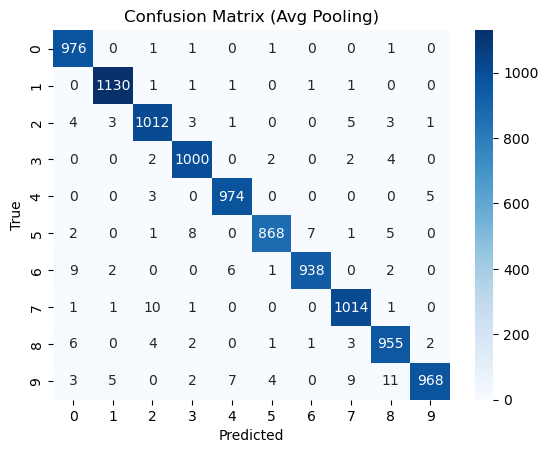

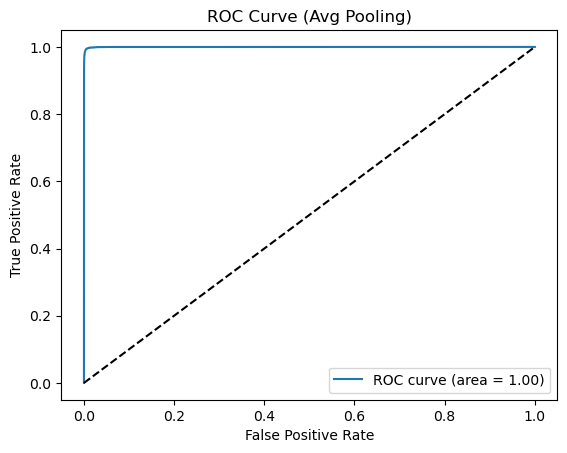

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import seaborn as sns

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define different CNN models
def create_strided_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1), strides=(2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def create_maxpool_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def create_avgpool_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.AvgPool2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def train_and_evaluate(model, x_train, y_train, x_test, y_test, name):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=64)
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(f"Classification Report ({name}):")
    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({name})')
    plt.legend()
    plt.show()

# Train and evaluate different models
train_and_evaluate(create_strided_model(), x_train, y_train, x_test, y_test, "Strided Conv")
train_and_evaluate(create_maxpool_model(), x_train, y_train, x_test, y_test, "Max Pooling")
train_and_evaluate(create_avgpool_model(), x_train, y_train, x_test, y_test, "Avg Pooling")
